In [1]:
import cv2
import numpy
import matplotlib.pyplot as plt
from wand.image import Image
import mediapipe as mp
import os

Note to self - I had to install ImageMagick (https://imagemagick.org/script/download.php#windows) and install Wand to convert MEIC to JPG

In [ ]:
!pip install Wand

In [2]:
def plot_image(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img, cmap='gray')
    plt.show()
    
def plot_image_color(img):
    fig = plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.show()

#### Analysis of "Bad Images"
- ie) images that cannot be detected with the frontal face classifier [we're assuming we can actually detect something for our model]
- **run anytime you add new images to your training set**
- **This is done so that each image is guaranteed to be transformed with face detection cropping**

In [38]:
DIR = '../images_jpg/'

def detect_bad_samples():
    count = 0
    for img in os.listdir(f'{DIR}'):
        img_jpg = cv2.imread(f'{DIR}{img}')
        img_jpg = cv2.resize(img_jpg, None, fx=0.1, fy=0.1, interpolation=cv2.INTER_CUBIC)
        face = face_cascade.detectMultiScale(img_jpg, 1.1, 4)
        print(face)
        try :
            face[0]
            continue
        except:
            count += 1
            print(img)
    print(count)

In [39]:
detect_bad_samples()

[[ 64 109 107 107]]
[[ 67 109 107 107]]
[[ 64 107 108 108]]
[[ 63 107 108 108]]
[[ 55  95 104 104]
 [ 89 217  53  53]]
[[ 79  95  90  90]
 [ 90 205  65  65]]
[[90 99 89 89]]
[[ 87 105 104 104]]
[[ 50 110 115 115]]
[[ 23 104 122 122]]
[[ 31  99 121 121]]
[[ 61  92 106 106]]
[[ 65  91 109 109]]
[[ 81 103 103 103]]
[[ 84 104 105 105]]
[[ 62 100 110 110]]
[[ 60 102 105 105]
 [ 81 196  78  78]]
[[ 60 102 105 105]
 [ 83 198  72  72]]
[[ 62 101 107 107]]
[[ 66 100 111 111]]
[[ 70 100 110 110]]
[[ 70 100 108 108]]
[[ 72 100 107 107]]
[[ 71  99 106 106]]
[[ 71 100 104 104]]
[[ 71 101 106 106]]
[[ 71 100 106 106]]
[[ 68 100 108 108]]
[[ 52  97 104 104]]
()
IMG_5488.JPG
[[91 93 90 90]]
[[103 103  99  99]]
[[132 118  57  57]]
()
IMG_5492.JPG
[[137 118  57  57]]
[[110 104 113 113]]
[[ 48 109 121 121]]
[[ 41 106 120 120]]
[[ 47  90 105 105]]
[[ 46  87 109 109]]
[[ 73  82 117 117]]
[[ 76  83 115 115]]
[[ 76 105 114 114]]
[[ 65 127 122 122]]
[[ 42 114 117 117]]
[[ 29  92 114 114]]
[[ 27  92 111 111]]


### TODO: Data Preprocessing
- Create Hold out Data to preserve original non-transformed images [DO NOT JUST THROW OUT WHAT YOU HAVE]
- See if model does well predicting on cropped images using models trained on uncropped compressed images 
- Try to figure out face detection with masks further [SOLUTION: JUST ADD THE ONES THAT WORK WITH MASK DETECTION - JUST ADD MORE TRAINING DATA!]
- **for Face detection, can convert to grayscale first and then do operations!**
- **for Face detection, use MediaPipe FACE DETECTION model instead of Haar Cascades

### TODO: Get Facemask Video Detection Working
- You want to have a producable demo!

In [3]:
faceDetect = mp.solutions.face_detection
detection = faceDetect.FaceDetection()
RESIZE_DIM = 34

def detect_face_boundaries(img):
    IMG_H, IMG_W = img.shape[0], img.shape[1]
    processed = False
    boundary_tuple = None
    result = detection.process(img)
    
    if result.detections:
        face = result.detections[0]
        box_info = face.location_data.relative_bounding_box
        x,y,w,h = int(box_info.xmin*IMG_W), int(box_info.ymin*IMG_H), int(box_info.width*IMG_W), int(box_info.height*IMG_H)
        boundary_tuple = (y,y+h,x,x+w)
        processed = True
        
    return boundary_tuple, processed

def apply_jpg_transform(img, color=False):
    # detect face and crop
    face_boundaries, processed = detect_face_boundaries(img)
    if not processed:
        return None, False
    
    R_START, R_END, C_START, C_END = face_boundaries
    # apply contrast balancing
    img = automatic_brightness_and_contrast(img)
    
    if not color:
        # Grayscale Processing
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    elif color:
        # Color Processing
        pass
    
    cropped_face = img[R_START:R_END, C_START:C_END]
    
    downsampled = cv2.resize(cropped_face, (RESIZE_DIM, RESIZE_DIM), interpolation = cv2.INTER_CUBIC)
    # get the width of the photo
    n = downsampled.shape[1] 
    n = n-1 if n%2==1 else n
    downsampled = cv2.resize(downsampled,(n, n))
    return downsampled, True

In [4]:
def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return auto_result

In [5]:
SOURCE_DIR="../images"
TARGET_JPG_DIR="../images_jpg"
MASK_JGP_DIR="../images_jpg_mask"
NO_MASK_JGP_DIR="../images_jpg_no_mask"
TARGET_GRAY_NO_MASK_DIR="../images_gray_transformed_no_mask"
TARGET_GRAY_MASK_DIR="../images_gray_transformed_mask"
TARGET_COLOR_NO_MASK_DIR="../images_color_transformed_no_mask"
TARGET_COLOR_MASK_DIR="../images_color_transformed_mask"

def convert_heic_to_jpg(filename):
    img_name, file_type = filename.split('.')
    img = Image(filename=f"{SOURCE_DIR}/{filename}")
    img.format = 'jpg'
    img.save(filename=f"{TARGET_JPG_DIR}/{img_name}.JPG")
    img.close()

def convert_pictures_to_jpg():     
    for heic_filename in os.listdir(f'{SOURCE_DIR}'):
        img_name, file_type = heic_filename.split('.')
        img = convert_heic_to_jpg(heic_filename)

def process_pictures(color=False):
    # for no mask
    target_no_mask_dir = TARGET_COLOR_NO_MASK_DIR if color else TARGET_GRAY_NO_MASK_DIR
    target_mask_dir = TARGET_COLOR_MASK_DIR if color else TARGET_GRAY_MASK_DIR
    
    for jpg_filename in os.listdir(f'{NO_MASK_JGP_DIR}'):
        img_name, file_type = jpg_filename.split('.')
        img = cv2.imread(f'{NO_MASK_JGP_DIR}/{img_name}.JPG')
        img, processed = apply_jpg_transform(img, color=color)
        if processed:
            cv2.imwrite(f'{target_no_mask_dir}/{img_name}.JPG', img)
        
#         print(jpg_filename)
#         if color:
#             plot_image_color(img)
#         else:
#             plot_image(img)
#         break
        
    # for mask
    for jpg_filename in os.listdir(f'{MASK_JGP_DIR}'):
        img_name, file_type = jpg_filename.split('.')
        img = cv2.imread(f'{MASK_JGP_DIR}/{img_name}.JPG')
        img, processed = apply_jpg_transform(img, color=color)
        if processed:
            cv2.imwrite(f'{target_mask_dir}/{img_name}.JPG', img)
        
#         print(jpg_filename)
#         if color:
#             plot_image_color(img)
#         else:
#             plot_image(img)
#         break

#### Convert HIEC FILES TO JPG
- manual sorting of mask vs non mask images is required

In [4]:
convert_pictures_to_jpg()

#### Preprocessing Images

In [68]:
process_pictures(color=False)

In [69]:
process_pictures(color=True)

### Scatch work

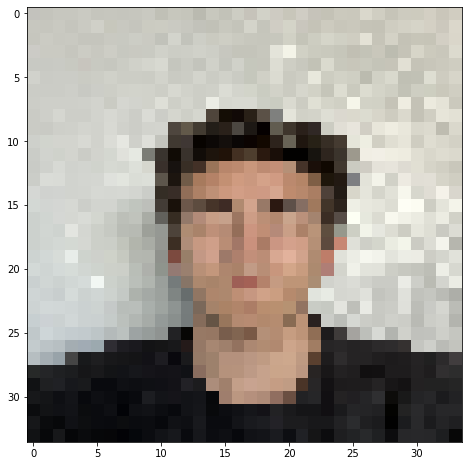

In [13]:
img = cv2.imread('../images_jpg_no_mask/IMG_5459.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2
res = cv2.resize(img, None, fx=0.05, fy=0.05, interpolation = cv2.INTER_CUBIC)
plot_image(res)

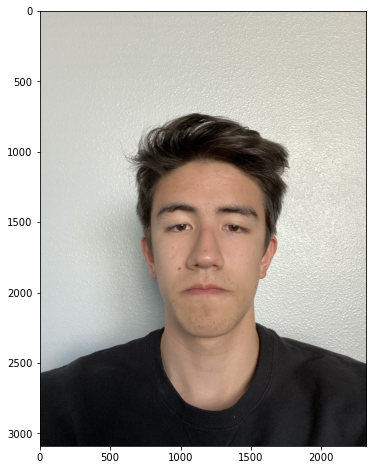

In [23]:
img = cv2.imread('../images_jpg_no_mask/IMG_5459.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_image_color(img)

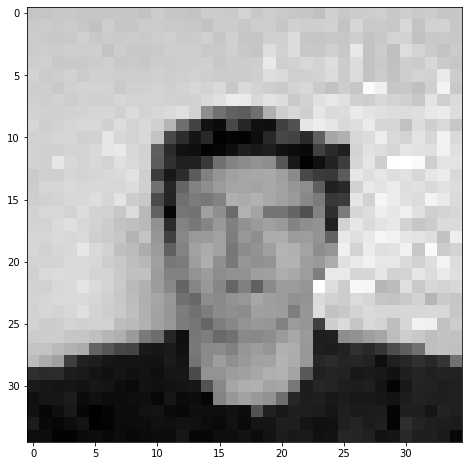

In [98]:
new_img = cv2.resize(res,(35, 35))
plot_image(new_img)

In [ ]:
TARGET_GRAY_NO_MASK_DIR="../images_gray_transformed_no_mask"
TARGET_GRAY_MASK_DIR="../images_gray_transformed_mask"
TARGET_COLOR_NO_MASK_DIR="../images_color_transformed_no_mask"
TARGET_COLOR_MASK_DIR="../images_color_transformed_mask"

In [30]:
nomask = ['IMG_5459', 'IMG_5493', 'IMG_837064129', 'IMG_837063099']
mask = ['IMG_5576', 'IMG_837068269', 'IMG_5663', 'IMG_837068657']
nomaskimg = [cv2.imread(f"{TARGET_GRAY_NO_MASK_DIR}/{name}.jpg", cv2.IMREAD_GRAYSCALE) for name in nomask]
maskimg = [cv2.imread(f"{TARGET_GRAY_MASK_DIR}/{name}.jpg", cv2.IMREAD_GRAYSCALE) for name in mask]

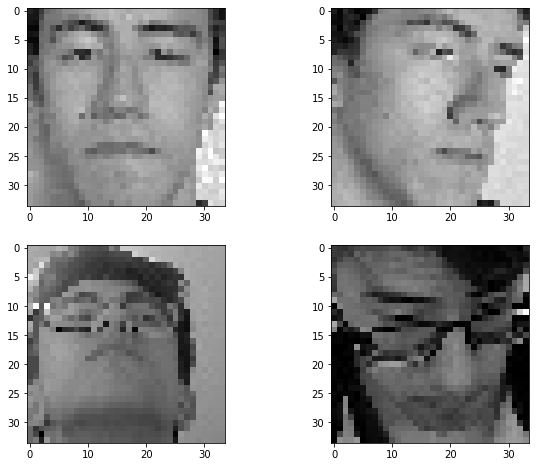

In [32]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes[0][0].imshow(nomaskimg[0], cmap='gray')
axes[0][1].imshow(nomaskimg[1], cmap='gray')
axes[1][0].imshow(nomaskimg[2], cmap='gray')
axes[1][1].imshow(nomaskimg[3], cmap='gray')
plt.savefig('nomaskpre.png')
plt.show()

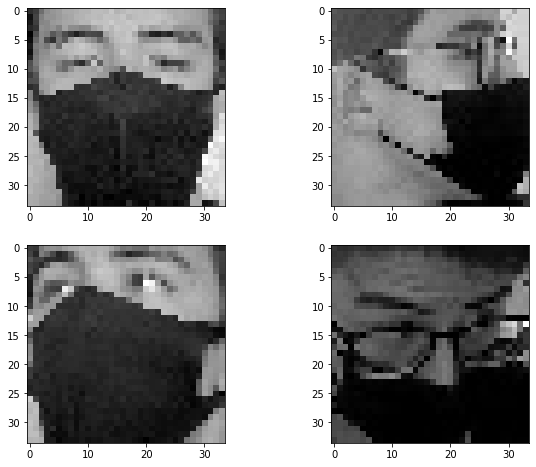

In [33]:
fig, axes = plt.subplots(2,2, figsize=(10,8))
axes[0][0].imshow(maskimg[0], cmap='gray')
axes[0][1].imshow(maskimg[1], cmap='gray')
axes[1][0].imshow(maskimg[2], cmap='gray')
axes[1][1].imshow(maskimg[3], cmap='gray')
plt.savefig('maskpre.png')
plt.show()

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(12,10))
axes[0][0].imshow()